In [ ]:
!pip install pytorch_model_summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.utils.prune as prune
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.init as init
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import numpy as np
from torchvision import datasets, models, transforms
from pytorch_model_summary import summary
import time
import copy, os
import matplotlib.pyplot as plt

%matplotlib inline

**Check for Device Availability**

In [ ]:
# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

Available device: cuda


**Prepare Dataset**

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**Model Definition**

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        DROPOUT = 0.1
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.dropout = nn.Dropout(DROPOUT)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.Dropout(DROPOUT)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out = self.dropout(self.bn3(self.conv3(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=-1)

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

**Load Pretrained Model**

In [ ]:
model = ResNet50()
#model.load_state_dict(torch.load("resnet_50.pth"))
model.load_state_dict(torch.load("resnet_50.pth"))
model.to(torch.device(device))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [ ]:
for layer, param in model.named_parameters():
    print(f"layer.name: {layer} & param.shape = {param.shape}")

layer.name: conv1.weight & param.shape = torch.Size([64, 3, 3, 3])
layer.name: bn1.weight & param.shape = torch.Size([64])
layer.name: bn1.bias & param.shape = torch.Size([64])
layer.name: layer1.0.conv1.weight & param.shape = torch.Size([64, 64, 1, 1])
layer.name: layer1.0.bn1.weight & param.shape = torch.Size([64])
layer.name: layer1.0.bn1.bias & param.shape = torch.Size([64])
layer.name: layer1.0.conv2.weight & param.shape = torch.Size([64, 64, 3, 3])
layer.name: layer1.0.bn2.weight & param.shape = torch.Size([64])
layer.name: layer1.0.bn2.bias & param.shape = torch.Size([64])
layer.name: layer1.0.conv3.weight & param.shape = torch.Size([256, 64, 1, 1])
layer.name: layer1.0.bn3.weight & param.shape = torch.Size([256])
layer.name: layer1.0.bn3.bias & param.shape = torch.Size([256])
layer.name: layer1.0.shortcut.0.weight & param.shape = torch.Size([256, 64, 1, 1])
layer.name: layer1.0.shortcut.1.weight & param.shape = torch.Size([256])
layer.name: layer1.0.shortcut.1.bias & param.shap

In [ ]:
def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):

    num_zeros = 0
    num_elements = 0

    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

In [ ]:
def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):

    num_zeros = 0
    num_elements = 0

    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

In [ ]:
def measure_global_sparsity_acc( model, testloader, device, weight = True,
    bias = False, conv2d_use_mask = False, linear_use_mask = False):

    num_zeros = 0
    num_elements = 0

    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):
            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

    sparsity = num_zeros / num_elements

    sparsity_percent = 100.0 * sparsity
    print("Global Sparsity: {:.2f}%".format(sparsity_percent))
    
    """
    Calculate the accuracy of the pruned model on the test set
    """
    num_correct = 0
    time_ = 0
    #Label =  0
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    for index, (inputs, targets) in enumerate(testloader):
      inputs, targets = inputs.to(device), targets.to(device)
      with torch.no_grad():
        start = time.time()
        outputs = model(inputs)
        pred = outputs.argmax(dim=1, keepdim=True)
        end = time.time()
        num_correct += pred.eq(targets.view_as(pred)).sum().item()
        time_ += end - start
    accuracy = 100*num_correct/len(testloader.dataset)   # Accuracy = numbr of correct outputs / total test samples
    print("Accuracy: {:.2f}%".format(accuracy))
    return [sparsity_percent, round(float(accuracy), 2), float(time_)/float(index)]

In [ ]:
# Iitializing list of k values
k_list = [val/100 for val in [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]]


1)  Perform Weight Pruning to prune away k% neurons/units for k in  [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

2)  Choose all layers other than the output layer and rank the weights using the absolute values
    by using the l1_unstructured function. 

3)  Calculate Sparsity in layers and the Accuracy of the Pruned model on the Test set.

In [ ]:
data = []
for k in k_list:
  model.eval()
  for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
      prune.l1_unstructured(module, name = 'weight', amount=k)
    elif isinstance(module, torch.nn.Linear):
      prune.l1_unstructured(module, name = 'weight', amount=k)
  data.append(measure_global_sparsity_acc(model, testloader, device))

Global Sparsity: 0.00%
Accuracy: 89.90%
Global Sparsity: 0.00%
Accuracy: 89.31%
Global Sparsity: 0.00%
Accuracy: 19.42%
Global Sparsity: 0.00%
Accuracy: 10.00%
Global Sparsity: 0.00%
Accuracy: 10.00%
Global Sparsity: 0.00%
Accuracy: 10.00%
Global Sparsity: 0.00%
Accuracy: 10.00%
Global Sparsity: 0.00%
Accuracy: 10.00%
Global Sparsity: 0.00%
Accuracy: 10.00%
Global Sparsity: 0.00%
Accuracy: 10.00%


In [ ]:
print(data)

[[0.0, 89.9, 0.010758129449991079], [0.0, 89.31, 0.013541722908998147], [0.0, 19.42, 0.0105247573974805], [0.0, 10.0, 0.01057653090892694], [0.0, 10.0, 0.010656688457880264], [0.0, 10.0, 0.010625059788043682], [0.0, 10.0, 0.01126955869870308], [0.0, 10.0, 0.011066348124773074], [0.0, 10.0, 0.01054756610821455], [0.0, 10.0, 0.010651837556790084]]


In [ ]:
data2 = [[0.0, 89.9, 0.010758129449991079], [25.0, 89.31, 0.013541722908998147], [50.0, 19.42, 0.0105247573974805], [60.0, 10.0, 0.01057653090892694], [70.0, 10.0, 0.010656688457880264], [80.0, 10.0, 0.010625059788043682], [90.0, 10.0, 0.01126955869870308], [95.0, 10.0, 0.011066348124773074], [97.0, 10.0, 0.01054756610821455], [99.0, 10.0, 0.010651837556790084]]

In [ ]:

# Plot sparsity/accuracy table
import pandas as pd
df = pd.DataFrame(data2,columns=['% Sparsity', '% Accuracy',"Execution Time"])
print(df) 

   % Sparsity  % Accuracy  Execution Time
0         0.0       89.90        0.010758
1        25.0       89.31        0.013542
2        50.0       19.42        0.010525
3        60.0       10.00        0.010577
4        70.0       10.00        0.010657
5        80.0       10.00        0.010625
6        90.0       10.00        0.011270
7        95.0       10.00        0.011066
8        97.0       10.00        0.010548
9        99.0       10.00        0.010652


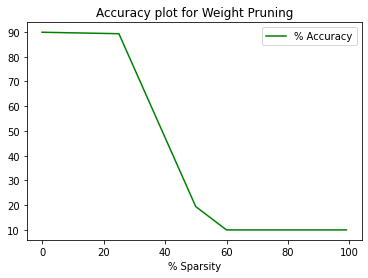

In [ ]:
# Plot accuracy plot for weight pruning
df.plot(kind='line', x = '% Sparsity', y='% Accuracy', color='green')
plt.title('Accuracy plot for Weight Pruning')
plt.show()

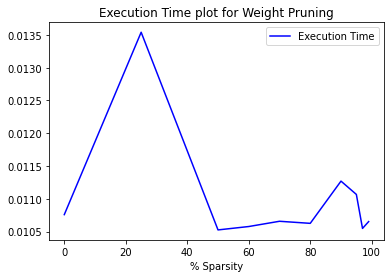

In [ ]:
df.plot(kind = 'line', x = '% Sparsity', y = "Execution Time", color = 'blue')
plt.title("Execution Time plot for Weight Pruning")
plt.show()